In [1]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')
import sys
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm

#TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

#绘图
import matplotlib.pylab as plt
import seaborn as sns

#参数风格
pd.set_option ('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions (precision=5, suppress=True) # numpy
pd.set_option('display.max_columns', 100) 
pd.set_option ('display.max_rows', 100)
sns.set(style='whitegrid', context='notebook') #ticks,notebook

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

path = r'D:/CASA-Dissertation/511/'

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7),style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
df=pd.read_csv(path + '5yearbj.csv',index_col=0,parse_dates=[0])
date=df[['rent_persquare']]
#date= df1.rename(columns={'Date':'Dates','Total flow':'Total_flow'},inplace = False)
date.tail(5)
date_train = date.loc['2018-01':'2022-05'] #训练模型

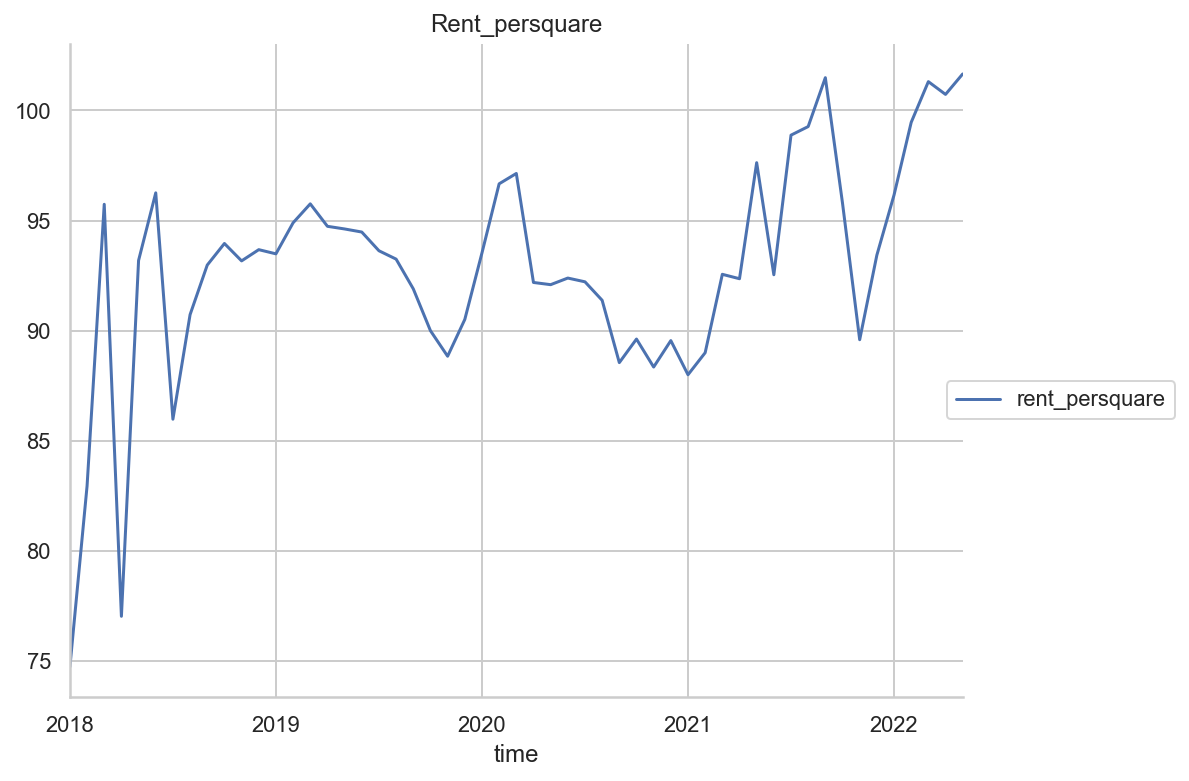

<Figure size 432x288 with 0 Axes>

In [4]:
date_train.plot(figsize = (8,6))
plt.title("Rent_persquare")
plt.legend(bbox_to_anchor =(1.25,0.5))
sns.despine()
plt.show()
plt.savefig('./Fig 1.1.Rent.jpg')

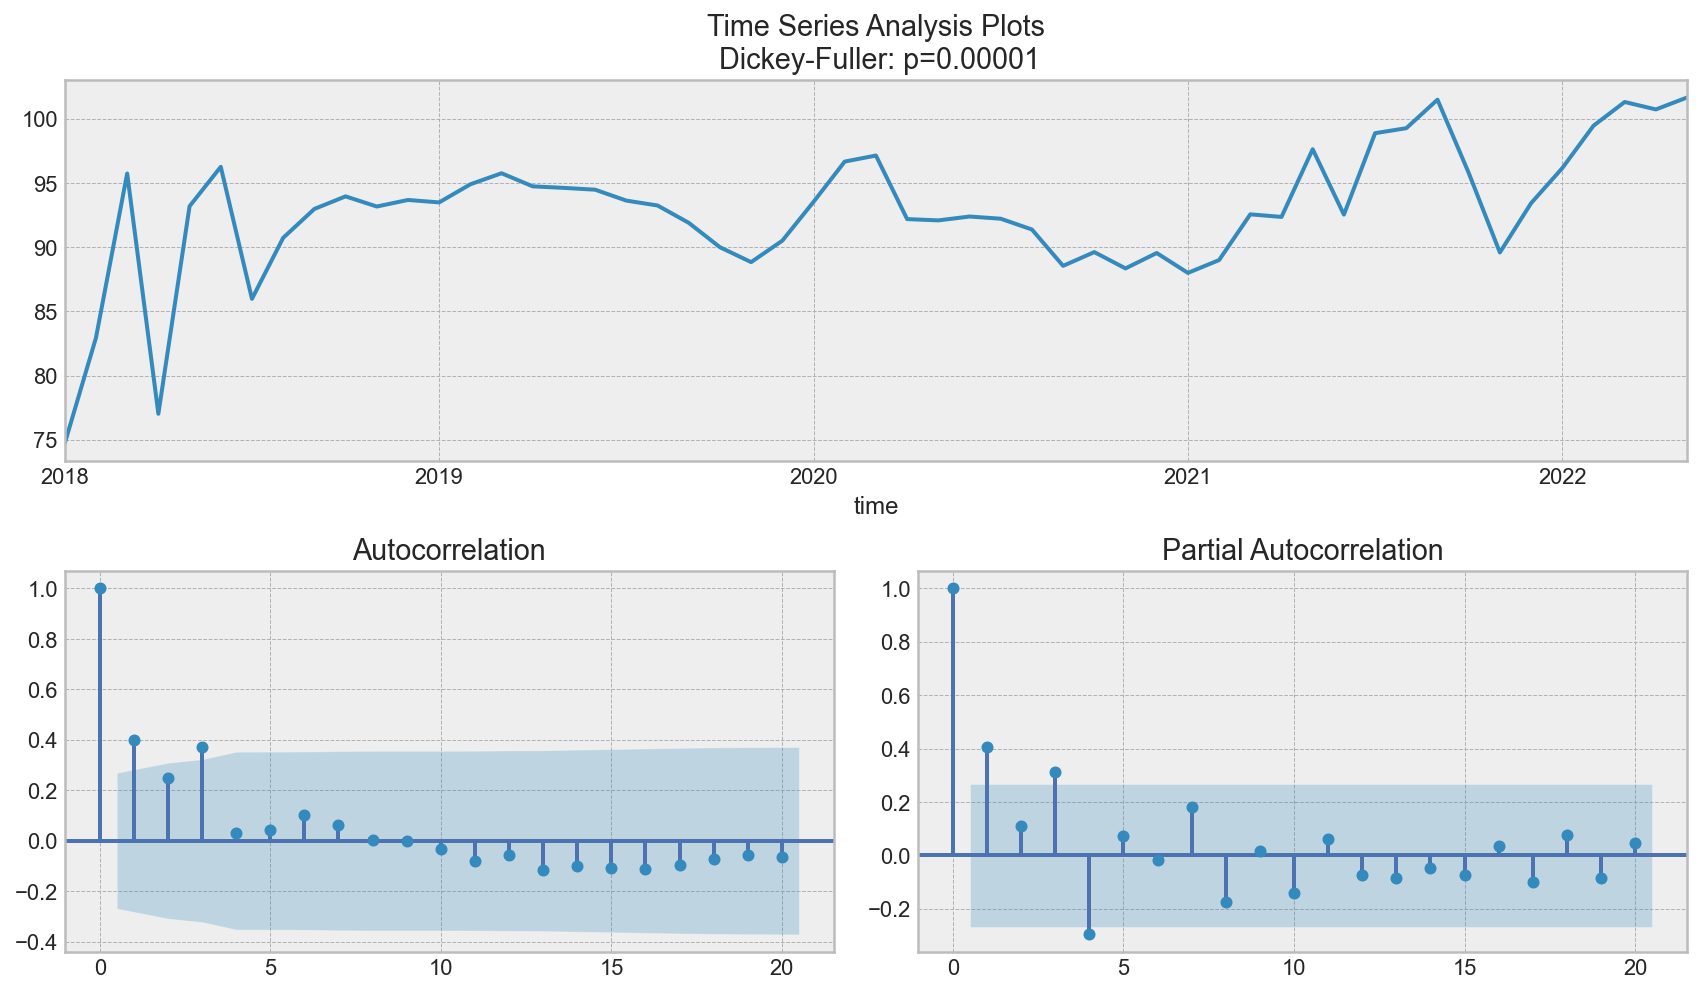

In [5]:
tsplot(date_train.rent_persquare, lags=20) # 20 Hysteresis quality
plt.savefig('./Fig 1.2.Date flow Time series.jpg')

In [6]:
# ADF test for stationarity

# Unsteady, then first diff

# Stationarity test after diff

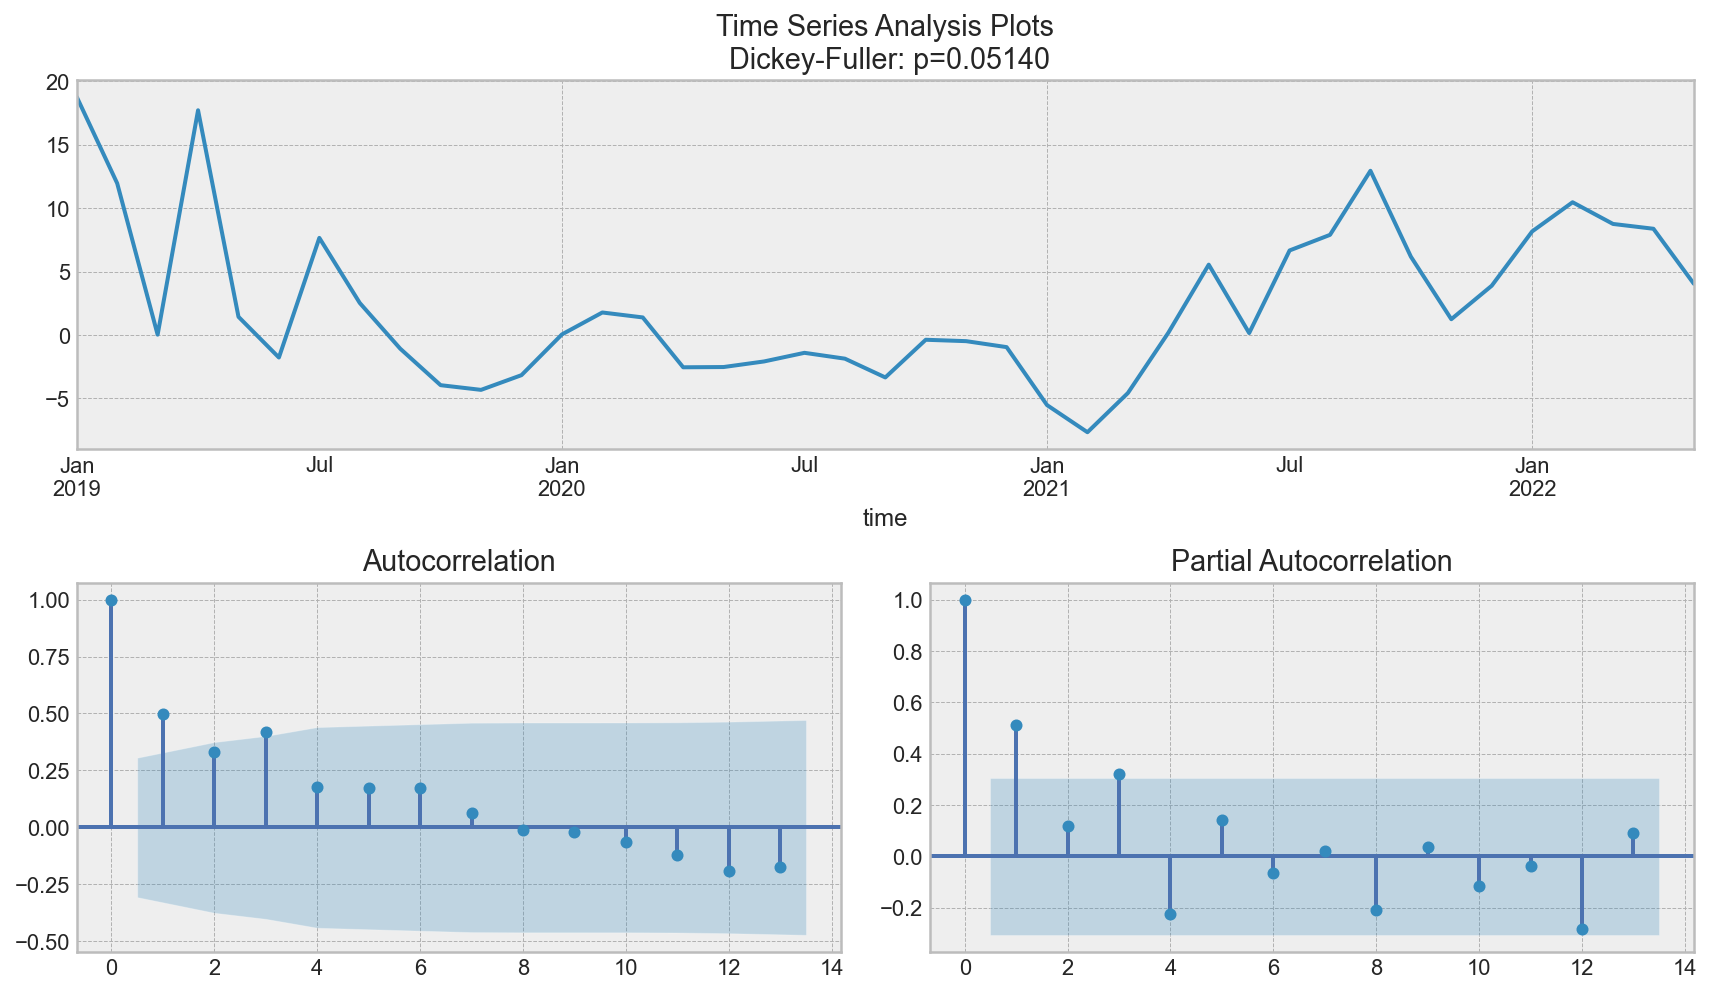

In [7]:
# Seansonal impacts
dt_diff = date_train.rent_persquare - date_train.rent_persquare.shift(12)
tsplot(dt_diff[12:], lags=13)

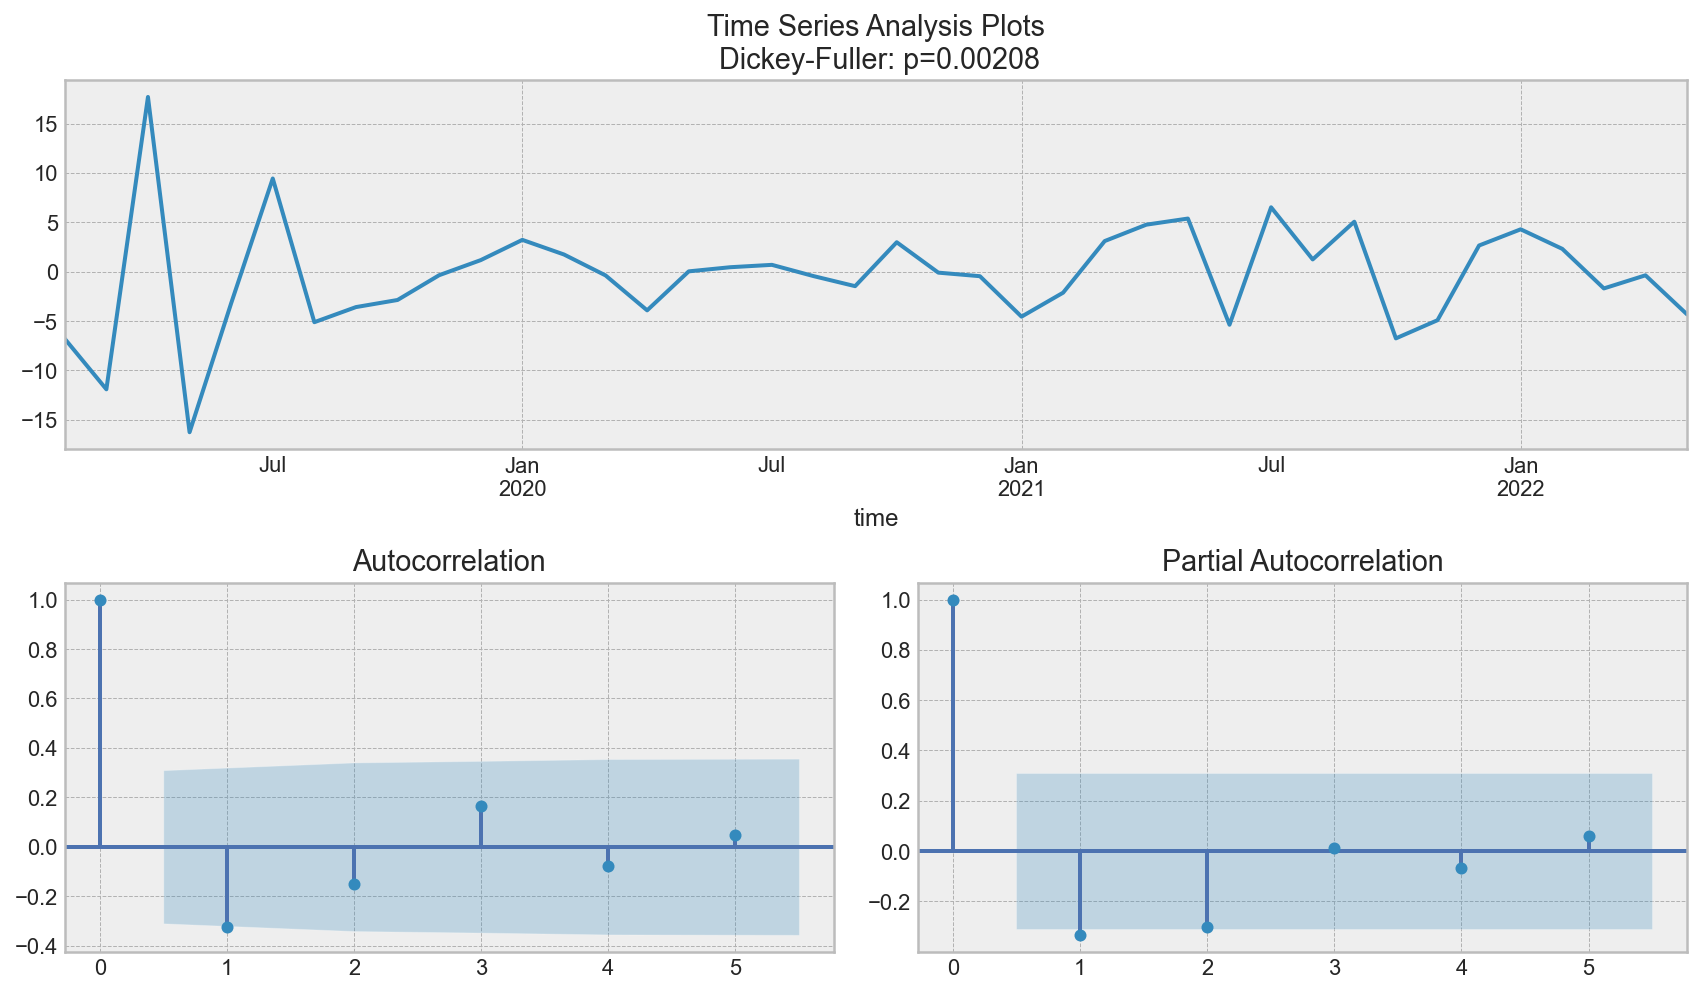

In [8]:
dt_diff2 = dt_diff - dt_diff.shift(1)
tsplot(dt_diff2[12+1:], lags=5)

In [9]:
# DIF
# Augmented Dickey-Fuller Unit Root Test
# 1. ADF = -3.16, smaller than 5% 10%, means stable
# 2. P-value = 0.02，close to 0, means stable
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.stattools import adfuller
from numpy import log
diff2=dt_diff2.diff().dropna() #0阶差分
adftest_diff2 = adfuller(diff2,autolag = 'AIC')
print(adftest_diff2)

(-3.1623018318428042, 0.022273151353985814, 6, 32, {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 153.31907785841082)


In [10]:
# setting initial values and some bounds for them
ps = range(0, 3)
d=1 
qs = range(0, 3)
Ps = range(0, 3)
D=1 
Qs = range(0, 3)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)  # 140

81

In [11]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(date_train.rent_persquare, parameters_list, d, D, s)

result_table

  0%|          | 0/81 [00:00<?, ?it/s]

,parameters,aic
0,"(2, 0, 0, 1)",245.47160
1,"(2, 0, 1, 0)",245.66377
2,"(2, 1, 0, 1)",245.71812
3,"(2, 1, 1, 0)",246.09215
4,"(0, 1, 1, 0)",246.78143
5,"(0, 1, 0, 1)",246.86423
6,"(2, 0, 2, 0)",247.04971
7,"(2, 0, 0, 2)",247.09181
8,"(2, 0, 1, 1)",247.15584
9,"(2, 1, 2, 0)",247.19931


In [12]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

model=sm.tsa.statespace.SARIMAX(date, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       rent_persquare   No. Observations:                   65
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -118.736
Date:                              Sun, 28 Aug 2022   AIC                            245.472
Time:                                      01:56:58   BIC                            253.277
Sample:                                  01-01-2018   HQIC                           248.464
                                       - 05-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5757      0.134     -4.285      0.000      -0.839      -0.312
ar.L2         -0.45

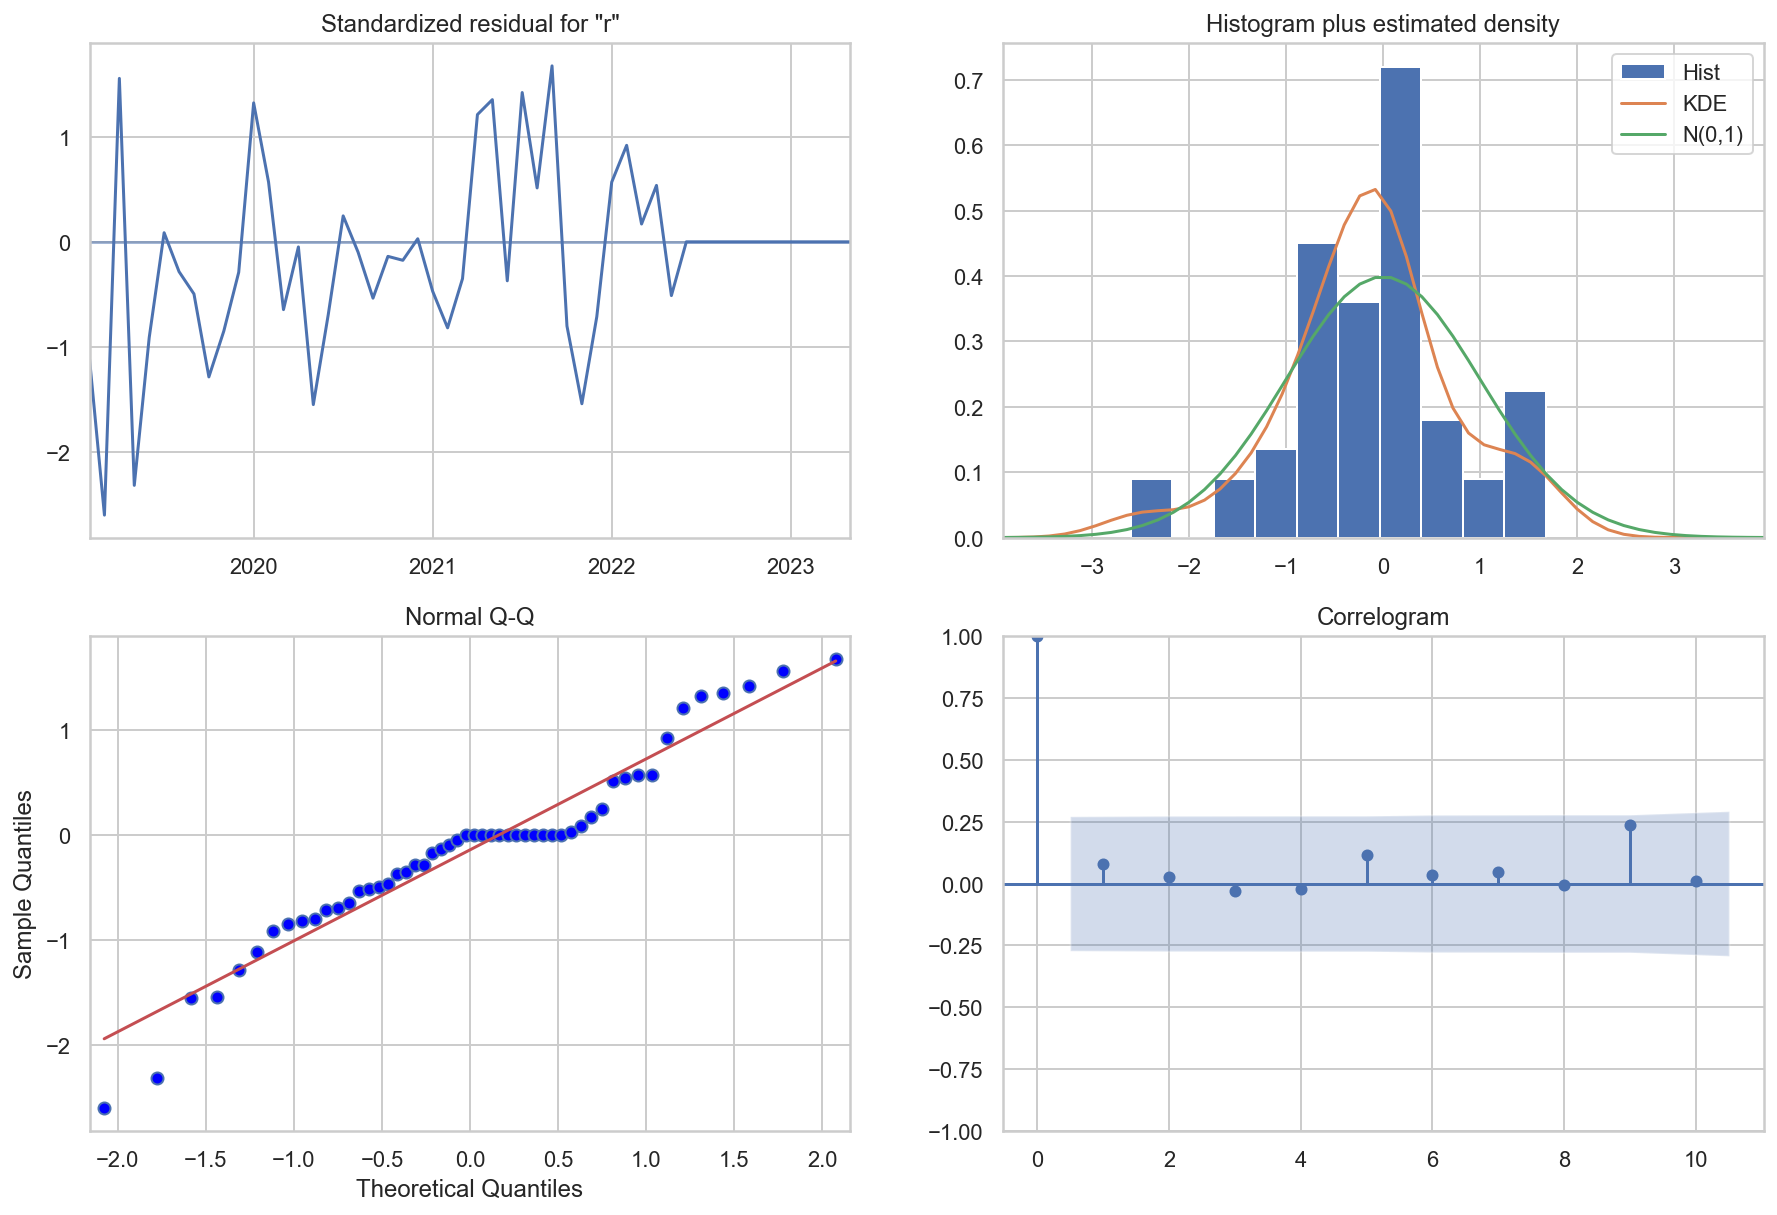

In [13]:
# 诊断
model.plot_diagnostics(figsize=(15, 10))
plt.show()
#由模型诊断结果可知：观察残差的时序图，可以看到残差基本稳定，随着时间的波动并没有很大的波动。
#观察正态分布图和QQ图，模型的残差是基本服从正态分布的。
#观察残差的自相关图，可以看到残差不存在自相关，说明残差序列是白噪声序列。
#从残差中不能再提取任何信息。因此可以得出结论，SARIMAX(8, 1, 4)x(3, 1, 0, 30)模型的拟合效果较好。

In [14]:
# D-W Durbin-Watson检验,接近2即p=0 不存在自相关. =4即p= -1 负相关
print(sm.stats.durbin_watson(model.resid.values))

nan


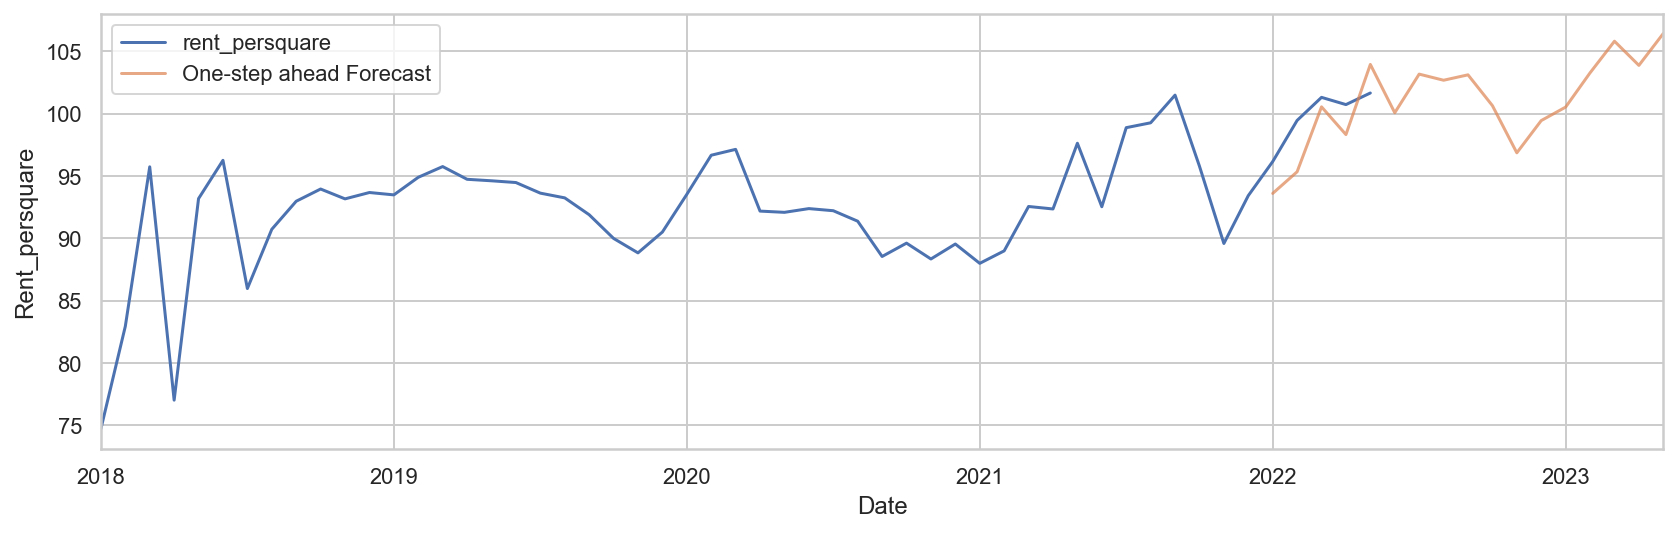

In [15]:
pred = model.get_prediction(start=pd.to_datetime('2022-01-01'),end=pd.to_datetime('2023-05-01'),dynamic=False)
pred_ci = pred.conf_int()
ax = date.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
#ax.fill_between(pred_ci.index,
                #pred_ci.iloc[:, 0],
                #pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Rent_persquare')
plt.legend()
plt.savefig('./Fig 3.SARIMAX Flow.png', dpi=500,transparent = True)
plt.show()